<a href="https://colab.research.google.com/github/MasaAsami/LTsandox/blob/main/noteooks/chp6_intro_ml_for_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 3.8 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=f3c48acfc3c13ea47bf107c4e96cb6caeaf69d54518e889416928d91d01ff46c
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [66]:
# @title import pkg

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.style.use(
#     "fivethirtyeight"
    "ggplot"
)  # https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html

import seaborn as sns

%matplotlib inline

### 高村 大也「言語処理のための機械学習入門」輪読会資料

# 第6章 実験の仕方など


## 6.2 分類問題の実験の仕方


In [9]:
# @title sample data
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
_target= pd.Series(data=[iris.target_names[i] for i in iris.target], name="target")
df = pd.concat([df,_target], axis=1)
df.columns = [
    "sepal_length"
    ,"sepal_width"
    ,"petal_length"
    ,"petal_width"
    ,"target"
    ]
del _target
del iris
df.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,target
105,7.6,3.0,6.6,2.1,virginica
28,5.2,3.4,1.4,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
86,6.7,3.1,4.7,1.5,versicolor
2,4.7,3.2,1.3,0.2,setosa
127,6.1,3.0,4.9,1.8,virginica
20,5.4,3.4,1.7,0.2,setosa
117,7.7,3.8,6.7,2.2,virginica
149,5.9,3.0,5.1,1.8,virginica
84,5.4,3.0,4.5,1.5,versicolor


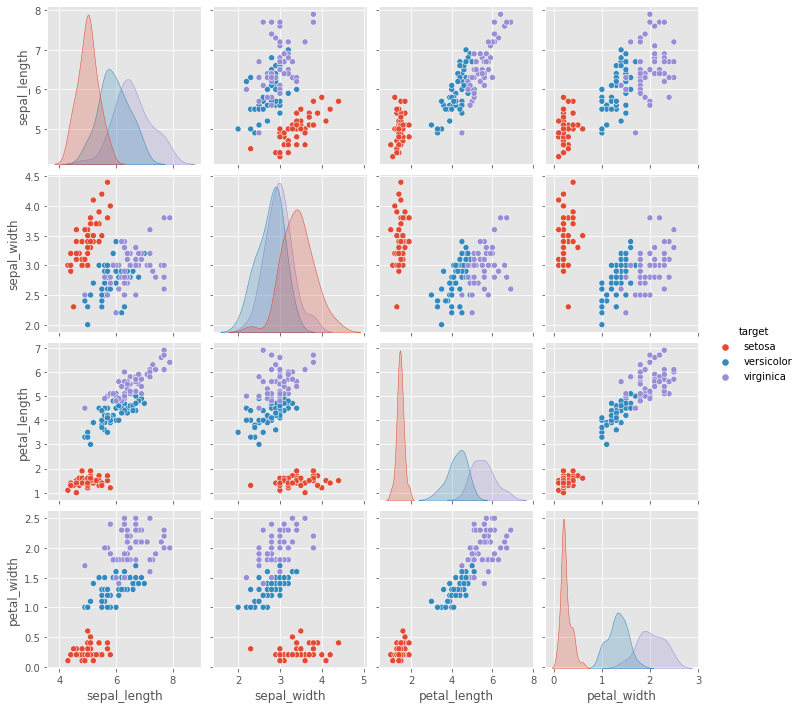

In [10]:
sns.pairplot(df, hue='target')

### あえてイージワークなラベルと特徴量を消す

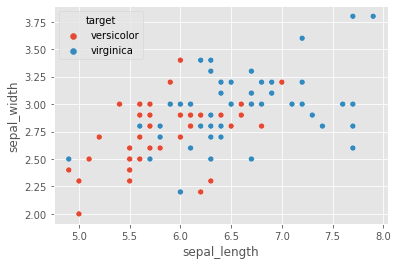

In [11]:
# @title "setosa" はイージータスクなので、除く。変数も絞る
df = df[["sepal_length", "sepal_width", "target"]].query("target != 'setosa'").reset_index(drop=True)

sns.scatterplot(
    x="sepal_length",
    y="sepal_width",
    hue="target", 
    data=df
)

### アンチパターン
## ダメエンジニアの発言「正解率９０％の分類モデルできた！！納品するよ！」

In [24]:
X = df.drop(columns=["target"])
y = np.where(df["target"] == "versicolor", 1 , 0)

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.3, random_state=0
  )

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

clf = SVC(gamma=100, C=1).fit(X_train, y_train)

y_pred = clf.predict(X_train)

print('confusion matrix = \n', confusion_matrix(y_true=y_train, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_train, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_train, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_train, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_train, y_pred=y_pred))

confusion matrix = 
 [[33  2]
 [ 3 32]]
accuracy =  0.9285714285714286
precision =  0.9411764705882353
recall =  0.9142857142857143
f1 score =  0.9275362318840579


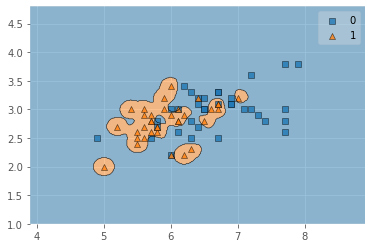

In [32]:
# @title 分類曲線
plot_decision_regions(
    X_train.values,
    y_train,
    clf=clf
  )

### これがoverfitting
- 何が悪いか、考えてみましょう
- また、どうすればよかった？


In [35]:
# @title 未知のデータ(test data)では、、、
y_pred = clf.predict(X_test)
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[9 6]
 [9 6]]
accuracy =  0.5
precision =  0.5
recall =  0.4
f1 score =  0.4444444444444445


### overfittingに気づこう
- overfitting：学習器の表現力を必要以上に高くしてしまい、ノイズにまで反応してしまうこと
- 学習に使っていないデータで必ずパフォーマンスを確認しながら、ハイパーパラメータ （モデルの表現力）を調整しよう

- イメージ（爆論）
  - 一つの会社に過剰適応してしまう（ハンコでお辞儀する系）人と
  - どんな企業でも転職できるような人、どっちが幸せ？


In [47]:
### overfittingに気づこう
from sklearn.model_selection import GridSearchCV

C_range = 10. ** np.arange(-5, 5)
gamma_range = 10. ** np.arange(-5, 4)

param_grid = dict(gamma=gamma_range, C=C_range)

grid = GridSearchCV(
    SVC(), 
    param_grid=param_grid,  
    cv=5  
)

grid.fit(X_train, y_train)

print("The best classifier is: ", grid.best_estimator_)


The best classifier is:  SVC(C=10.0, gamma=10.0)


In [55]:
best_clf = SVC(gamma=grid.best_params_["gamma"], C=grid.best_params_["C"]).fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_test, y_pred=y_pred))
print('precision = ', precision_score(y_true=y_test, y_pred=y_pred))
print('recall = ', recall_score(y_true=y_test, y_pred=y_pred))
print('f1 score = ', f1_score(y_true=y_test, y_pred=y_pred))

confusion matrix = 
 [[8 7]
 [6 9]]
accuracy =  0.5666666666666667
precision =  0.5625
recall =  0.6
f1 score =  0.5806451612903225


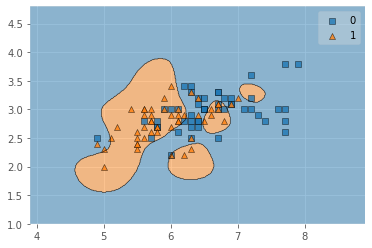

In [57]:
plot_decision_regions(
    X.values,
    y,
    clf=best_clf
  )

## 6.3 評価指標
- ここは読めばわかるので、詳細は教科書よんでくださいね
- とても、大事なところです。MLプロジェクトにとって、
- どの評価指標を設定するかはビジネスゴールを吟味しながらしっかり決めて行こう

In [62]:
# @title ダメダメ評価指標 正解率99%のモデルつくりました
y_pred = [0 for _ in range(100)]
y_true = [1 if i == 0 else 0 for i in range(100)]

# print('confusion matrix = \n', confusion_matrix(y_true=y_true, y_pred=y_pred))
print('accuracy = ', accuracy_score(y_true=y_true, y_pred=y_pred))
print("正解率99%のモデルすごい！！！、、、、？")

accuracy =  0.99
正解率99%のモデルすごい！！！、、、、？


#### ケーススタディ　不正検知の高度化プロジェクト
As-Is : 現場職員が全申請書を熟読して、不正申請を検知。職員の審査能力に現状課題感はないものの、全申請を同じ労力で審査するのはもう疲れた<br>
<br>
提案：機械学習で解決しよう（「不正/適正」の二値分類問題）<br>

<br>

あなたはどの評価指標を選び、どのような業務フローを提案しますか？

## 6.4 検定
- 一番有名なt-検定から
- 個人的にはあまり検定という考え方は（**宗教上の理由により**）好きじゃないのですが、教科書的な明くらいは覚えておきましょう

In [63]:
#@title サンプルデータ 両群の差は3
np.random.seed(seed=10)
case_base = 100
case_effect = 3

case1_std = 5
case2_std = 50

base_size = 30

treatment_1 = np.random.normal(case_base + case_effect, case1_std, size=base_size)

control_1 = np.random.normal(case_base, case1_std, size=base_size)

treatment_2 = np.random.normal(case_base + case_effect, case2_std, size=base_size)
control_2 = np.random.normal(case_base, case2_std, size=base_size)

treatment_1_mean = np.mean(treatment_1)
control_1_mean = np.mean(control_1)

treatment_2_mean = np.mean(treatment_2)
control_2_mean = np.mean(control_2)

Text(0.5, 1.0, '[仮想case2] 標準偏差 :50, 平均の差は3.5716120628424477')

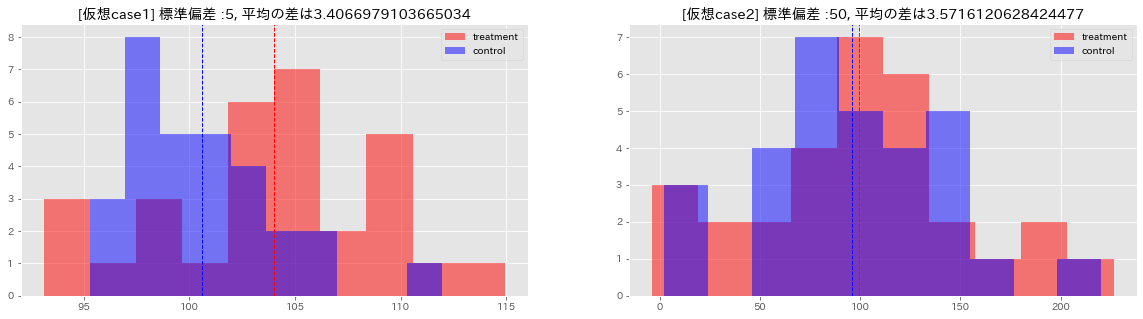

In [67]:
# @title 両ケースとも差は３だけど、、、
fig, axs = plt.subplots(1, 2, figsize=(20, 5), facecolor="w", edgecolor="k")
# ヒストグラム
axs[0].hist(treatment_1, label="treatment", alpha=0.5, color="r")
axs[0].hist(control_1, label="control", alpha=0.5, color="b")
axs[0].legend()
axs[0].axvline(treatment_1_mean, color="r", linestyle="dashed", linewidth=1)
axs[0].axvline(control_1_mean, color="b", linestyle="dashed", linewidth=1)
axs[0].set_title(
    f"[仮想case1] 標準偏差 :{case1_std}, 平均の差は{treatment_1_mean - control_1_mean}"
)

axs[1].hist(treatment_2, label="treatment", alpha=0.5, color="r")
axs[1].hist(control_2, label="control", alpha=0.5, color="b")
axs[1].legend()
axs[1].axvline(treatment_2_mean, color="r", linestyle="dashed", linewidth=1)
axs[1].axvline(control_2_mean, color="b", linestyle="dashed", linewidth=1)
axs[1].set_title(
    f"[仮想case2] 標準偏差 :{case2_std}, 平均の差は{treatment_2_mean - control_2_mean}"
)

- case1, case2とも、2群の平均値の差は3になるようにデータを作っています
- 直感的に、どっちの方が**「差がある」**と言えそうですか？（case1の方が差があるっぽく見えますよね？）
- 平均値の差を比べる際には、単純な差の規模だけでなく、分布のばらつき具合も評価しないと適切な判断ができないわけです
<br>
- ここで考えられたのが ** t値及びt検定 **です。
- 色々なバリエーションや、正規分布を仮定する等、諸々細かいことは最初は無視しましょう

#### [t値]
- イメージ：2群の平均値の差を分散で調整したもの
- 各群の平均値を$\overline{ X }$, $\overline{ Y }$
- 各群の不偏分散を $s_{x}^2$, $s_{y}^2$
- 各群のサンプルサイズをm, n
$$
t値(2群・不等分散)= \frac{ \overline{ X } – \overline{ Y }}{\sqrt[]{ s_{x}^2 / m + s_{y}^2 / n} }
$$

- 平均値の差が大きい -> t値 up
- 分散（ばらつき）が大きい -> t値 dwn

In [68]:
v_t, v_c = np.var(treatment_1, ddof=1), np.var(control_1, ddof=1)
mean_diff = treatment_1_mean - control_1_mean

t_value = mean_diff / np.sqrt((v_t + v_c) / base_size)
print("case1のｔ値: ", t_value)

case1のｔ値:  2.904467870564121


#### これはどの程度ありえないこと？
- **もし両群の平均の差がなかったと仮定する**
- この時、今回計測さえれたt値以上の極端な差がどれ程度ありえない状態なのかをチェックする
- ｔ値は(適切な自由度の)t分布に従うことがわかっているので、このありえなさはチェックできる

p-value:  0.005197862099315609


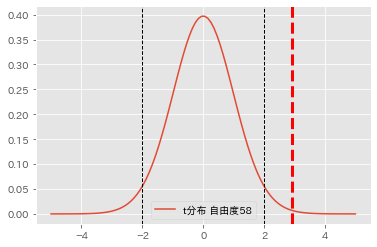

In [69]:
# 有意水準5%の場合
dof = base_size * 2 - 2
t_lower = stats.t.ppf(0.025, dof)
t_upper = stats.t.ppf(1 - 0.025, dof)

x = np.linspace(-5, 5, 100)

t = stats.t.pdf(x, dof)
plt.plot(x, t, label=f"t分布 自由度{dof}")
plt.axvline(t_value, color="r", linestyle="dashed", linewidth=3)
plt.axvline(t_lower, color="k", linestyle="dashed", linewidth=1)
plt.axvline(t_upper, color="k", linestyle="dashed", linewidth=1)
plt.legend()
print("p-value: ", 2 * (1 - stats.t.cdf(t_value, dof)))  # 両側検定なので2倍する

In [70]:
t_test_result1 = stats.ttest_ind(treatment_1, control_1, equal_var=True)  # ウェルチのt検定
t_test_result2 = stats.ttest_ind(treatment_2, control_2, equal_var=True)

print("case1 t値: ", t_test_result1.statistic)
print("case2 t値: ", t_test_result2.statistic)

print("case1 p値: ", t_test_result1.pvalue)
print("case2 p値: ", t_test_result2.pvalue)

case1 t値:  2.904467870564121
case2 t値:  0.26994082334467634
case1 p値:  0.005197862099315652
case2 p値:  0.7881639332065445


#### [注意] p値の意味
- 効果（差）がある確率？効果があることが正しい確率？
=> **もし効果（差）がなかったと仮定したときに、今回のデータ以上の極端な差が観察される確率**
- p値が小さいほど、効果が大きい！！ => **これも誤り**。p値の小ささと、効果の大きさは別問題（分散やサンプルサイズにp値は依存する）

see:
[The Difference Between “Significant” and “Not Significant” is not Itself Statistically Significant](https://www.tandfonline.com/doi/abs/10.1198/000313006X152649)

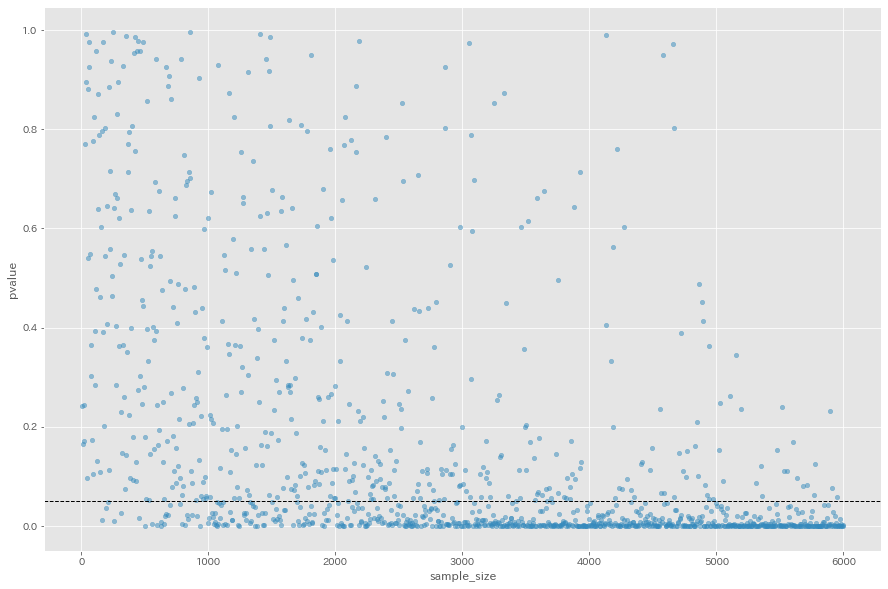

In [71]:
#@title 平均値の差、分散を固定してサンプルサイズだけ動かしてみる
result_dic = {}

for sample_size in range(10, 6001, 5):
    treatment_temp = np.random.normal(
        case_base + case_effect, case2_std, size=sample_size
    )
    control_temp = np.random.normal(case_base, case2_std, size=sample_size)

    result_dic[sample_size] = stats.ttest_ind(
        treatment_temp, control_temp, equal_var=True
    ).pvalue

sim_result_ttest = pd.DataFrame(result_dic, index=["pvalue"]).T.reset_index()
sim_result_ttest.columns = ["sample_size", "pvalue"]

sim_result_ttest.plot.scatter(x="sample_size", y="pvalue", alpha=0.5, figsize=(15, 10))
plt.axhline(0.05, color="k", linestyle="dashed", linewidth=1)